# Qarameterized circuits: Quantum parameters for QML

<span style="color:gray"> *So you want to train your quantum circuit but you're tired of optimizing everything **classically**...?*</span>.



Variational quantum circuits are the foundation of many near term quantum algorithms, from quantum chemistry to quantum machine learning. In most of these applications, parameters are optimized by using the quantum quantum circuit to compute a cost function for some initial choice of parameters, and then updating these parameters using a **classical** optimizer running in lockstep with the quantum circuits.

In this project we propose **Quantum-parameterized (Qarameterized) circuits** for the optimization of variational circuits.



### Motivation

 - why do we care about parameterized quantum circuit?
 - what kind of advantage do we expect from this implementation specifically

### Background

Training a parameterized quantum circuit requires that we find some set of angles $\theta$ that correspond to the extremum of an observable. If we think about circuits preparing parameterized states of the form

$$
|\psi(\theta)\rangle = U(\theta)|0\rangle
$$

then our goal is to minimize the value of some observable quantity $M$, that is

$$
\underset{\theta}{\operatorname{argmin}} \, \langle \psi(\theta) | M | \psi(\theta)\rangle
$$

Quantum parameterization has been proposed previously, for example [(Verdon, 2018)](https://arxiv.org/abs/1806.09729), but our algorithm improves the probability of finding circuit optima using a *gradient-free technique*.

### Building a Qarameterized circuit

In order to apply this optimization technique we prepare the circuit by "lifting" each parameter into quantum state space. This means that any gate that was previously parameterized by a classical number $\theta$ instead becomes controlled by quantum registers storing the binary expansion of $\theta = \sum_k \theta_k 2^{-k}$, up to some desired precision in the estimate of $\theta_{opt}$:

<img src="img/lifting_diagram/lifting_diagram.png" width=700 height=200 />

### Applying amplitude amplification to find $\theta_{opt}$

To realize an advantage in optimization, our algorithm queries the cost landscape for an observable $H$ *for a  superposition of choices of $\theta$*. To do so we employ an oracle that phases the ancilla register by $\exp (i H)$ that simultaneously modifies the amplitudes for every possible choice of $\theta$ stored in the ancillas.

**TODO**: Briefly explain the phase and diffusion layers. Also explain K hyperparameter

<img src="img/lifting_animation/lifting_animation.png" width=2000 height=913 />

### Experiments

We performed...

The circuit we used for this experiment is shown below. We also show how to modify a basic circuit to support optimization using this method by adding on a small ancillary system


circuit goes here

We used Grover search to optimize this circuit using the cost function XXX. Below we show how the algorithm updated optimal parameters at each step of the algorithm.

In [35]:
from src.qarameterize import RandomCircuit

NUM_QUBITS = 2
PRECISION = 5
SEED = 10

rc = RandomCircuit(num_qubits=NUM_QUBITS, precision_qparams=PRECISION, seed=SEED)

In [98]:
max_param = 2*np.pi
binwidth = 2*np.pi/2**PRECISION

param_0_binedges = np.linspace(0-binwidth/2, 2*np.pi+binwidth/2, num=2**PRECISION+1, endpoint=True)
param_1_binedges = np.linspace(0-binwidth/2, 2*np.pi+binwidth/2, num=2**PRECISION+1, endpoint=True)
param_0_binedges, param_1_binedges = np.meshgrid(param_0_binedges, param_1_binedges)

param_0_vals_flat = np.linspace(0, 2*np.pi, num=2**PRECISION, endpoint=False)
param_1_vals_flat = np.linspace(0, 2*np.pi, num=2**PRECISION, endpoint=False)
param_0_vals, param_1_vals = np.meshgrid(param_0_vals_flat, param_1_vals_flat)

# Evaluate the cost landscape for the random circuit
score_landscape = np.ones_like(param_0_vals) * 1e-3
for idx in np.ndindex(param_0_vals.shape):
    score_landscape[idx] = rc.target_prob([param_0_vals[idx], param_1_vals[idx]])

    
# Perform optimization on the circuit with quantum parameters
ampl_circuit, ampl_prob_func = rc.make_amplitude_amplification_circuit(num_qparams=2, K=1)
amplified_probs = ampl_prob_func(cparams=[])

probabilities = np.zeros_like(param_0_vals)
for idx in np.ndindex(param_0_vals.shape):
    probabilities[idx] = amplified_probs[idx]

In [100]:
probabilities.sum()

0.9999999999999949

In [101]:
center_idx = np.unravel_index(score_landscape.argmax(), score_landscape.shape)
center_idx

(28, 28)

In [104]:
s = 0
i0, j0 = center_idx
for i in [-3, -2, -1, 0, 1, 2, 3]:
    for j in [ -3, -2, -1, 0, 1, 2, 3]:
        s += probabilities[i0 + i, j0 + j]

print(probabilities.sum())
print(s)

0.9999999999999949
0.17724807419763347


(5.497787143782138, 5.497787143782138)


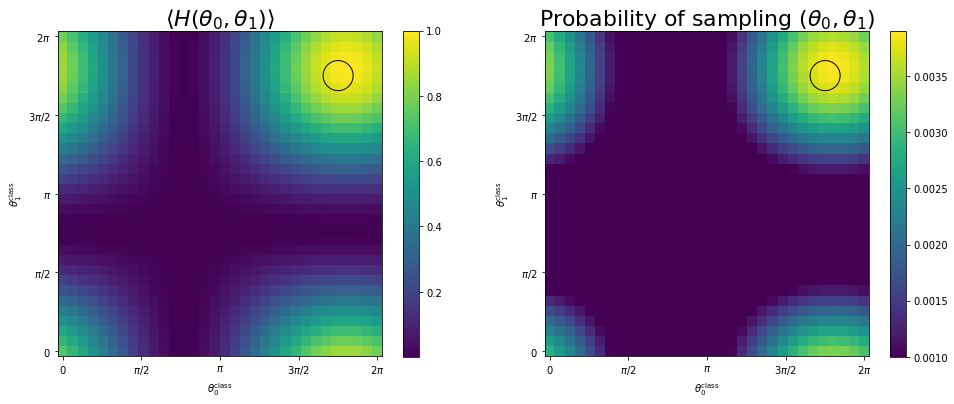

In [87]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from matplotlib.colors import LogNorm

roundoff = 1e-3
score_landscape[score_landscape < roundoff] = roundoff
probabilities[probabilities < roundoff] = roundoff


fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(16, 6))

_ = ax0.pcolormesh(param_0_binedges, param_1_binedges, score_landscape)
# _ = ax0.pcolormesh(param_0_binedges, param_1_binedges, score_landscape, norm=LogNorm(vmin=1e-3))
plt.colorbar(_, ax=ax0)
ax0.set_aspect('equal')
ax0.set_title(r'$\langle H(\theta_0, \theta_1) \rangle$', size=22)

_ = ax1.pcolormesh(param_0_binedges, param_1_binedges, probabilities)
# _ = ax1.pcolormesh(param_0_binedges, param_1_binedges, probabilities, norm=LogNorm(vmin=1e-3))
plt.colorbar(_, ax=ax1)
ax1.set_aspect('equal')
ax1.set_title(r'Probability of sampling $(\theta_0, \theta_1)$', size=22)


# Circle overlay
center_idx = np.unravel_index(score_landscape.argmax(), score_landscape.shape)
center = (param_0_vals_flat[center_idx[0]], param_1_vals_flat[center_idx[1]])
print(center)
circ = plt.Circle(center, 0.3 , fill = False ) 
  
# axes.set_aspect( 1 ) 
ax1.add_artist( circ ) 
circ2 = plt.Circle(center, 0.3 , fill = False ) 

ax0.add_artist( circ2 ) 



for ax in [ax0, ax1]:
    ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    ax.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    ax.set_xticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
    ax.set_yticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
    ax.set_xlabel(r'$\theta^\mathrm{class}_0$')
    ax.set_ylabel(r'$\theta^\mathrm{class}_1$')

# fig.suptitle(r"Score function for different $(\theta^\mathrm{class}_0, \theta^\mathrm{class}_1)$ values", y=1.02)
None

In [ ]:
def centered_arr_integrate(c, r):
    """Numerically integrate an array """

In [31]:
import matplotlib.pyplot as plt
import numpy as np

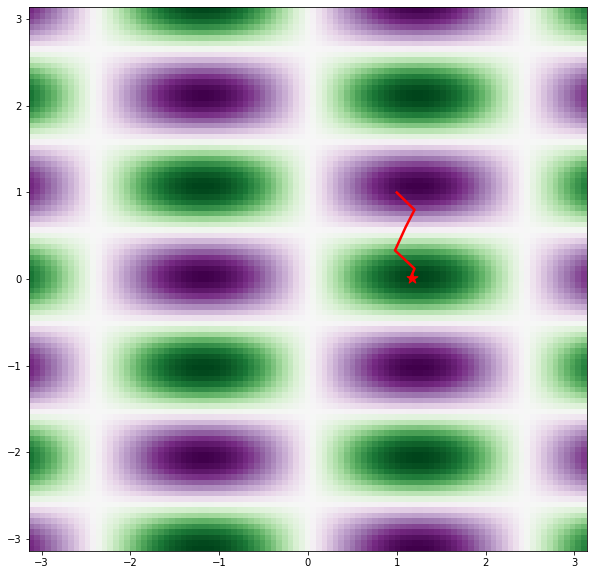

In [28]:
# Dummy cost fucntion; replace with something nice later
cost_func = lambda x, y: np.cos(3*x) * np.sin(1.3 * y)
algorithm_steps = np.asarray([(1, 1), (1.2, 0.8), (1.1, 0.6), (0.98, 0.33), (1.2, 0.12), (1.15, 0.00), (1.17, 0.01)])
steps_x, steps_y = zip(*algorithm_steps)
steps_x = np.asarray(steps_x)
steps_y = np.asarray(steps_y)

npts = 100
x = np.linspace(-np.pi, np.pi, npts)
y = np.linspace(-np.pi, np.pi, npts)
z = np.asarray([cost_func(xi, yj) for xi in x for yj in y])

X, Y = np.meshgrid(x, y)
Z = z.reshape(npts, npts)

cmap = 'PRGn'
stepscolor = 'r'
fig, ax = plt.subplots(figsize=(10, 10))
ax.pcolor(X, Y, Z, cmap=cmap)
ax.plot(steps_x, steps_y, c=stepscolor, lw=2.5)
ax.scatter(steps_x[-1], steps_y[-1], marker="*", s=130, c=stepscolor)

### Discussion

Grover serach for quantum circuit optimization presents an exciting opportunity blah blah blah